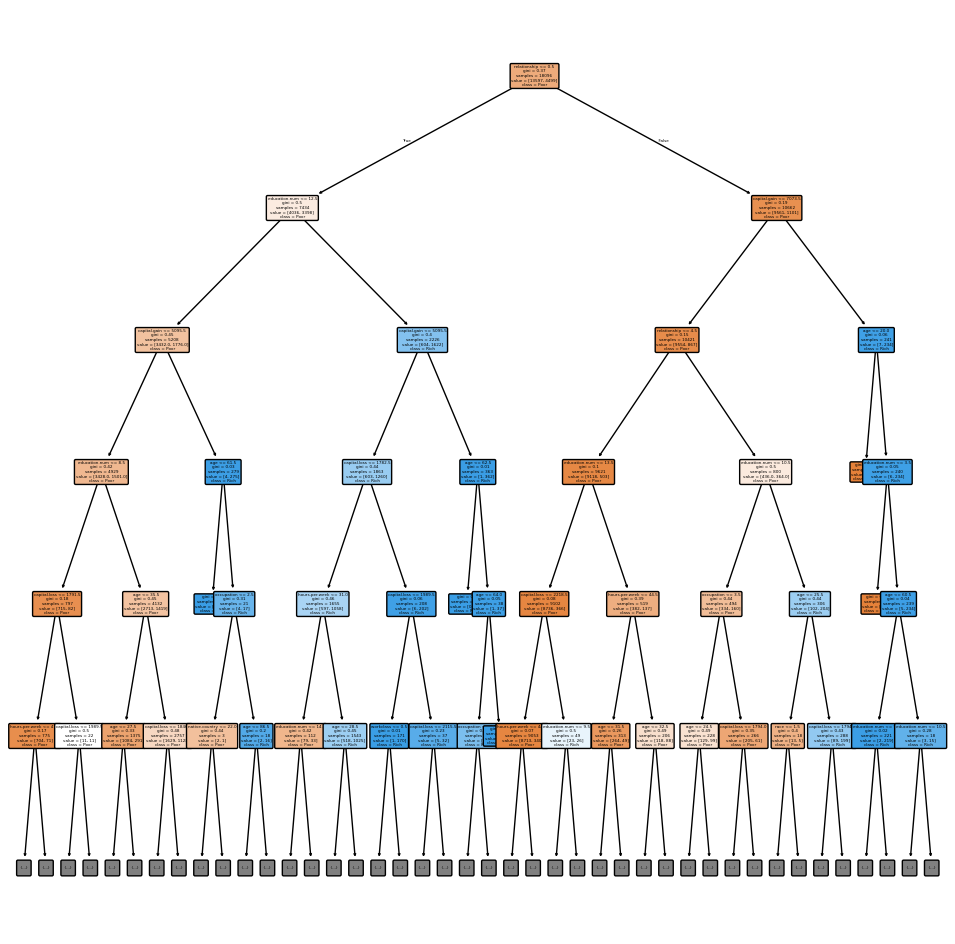

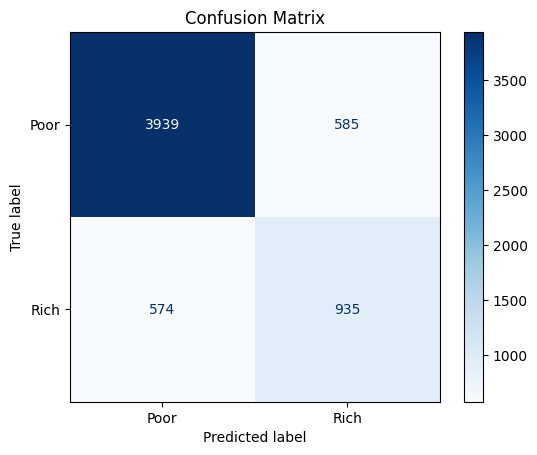

Classification Report:
              precision    recall  f1-score   support

        Poor       0.87      0.87      0.87      4524
        Rich       0.62      0.62      0.62      1509

    accuracy                           0.81      6033
   macro avg       0.74      0.75      0.74      6033
weighted avg       0.81      0.81      0.81      6033

<class 'pandas.core.frame.DataFrame'>
Index: 18096 entries, 13586 to 5836
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             18096 non-null  int64
 1   workclass       18096 non-null  int64
 2   education.num   18096 non-null  int64
 3   marital.status  18096 non-null  int64
 4   occupation      18096 non-null  int64
 5   relationship    18096 non-null  int64
 6   race            18096 non-null  int64
 7   sex             18096 non-null  int64
 8   capital.gain    18096 non-null  int64
 9   capital.loss    18096 non-null  int64
 10  hours.per.week  18096 

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint


# Load dataset
df = pd.read_csv('./Datasets/adult.csv', comment = '#')

# First, create a copy of the dataframe to avoid modifying the original
df_encoded = df.copy()
df_encoded.drop(['fnlwgt', 'education'], axis=1, inplace=True)

# drop all rows that contain '?'
for column in df_encoded.columns:
    df_encoded = df_encoded[df_encoded[column] != '?']

# Apply label encoding to categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['workclass', 'marital.status', 'occupation', 
                      'relationship', 'race', 'sex', 'native.country', 'income']

for column in categorical_columns:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

# Now properly separate features and target
X = df_encoded.drop(columns=['income'])
y = df_encoded['income']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


# Build pipeline
model = Pipeline([
    ('full_dt_classifier', DecisionTreeClassifier(random_state=42))  # Train Decision Tree Regressor
])

# Train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# Visualize the decision tree
plt.figure(figsize=(12, 12))
plot_tree(
    model.named_steps['full_dt_classifier'],
    feature_names=X.columns,
    class_names=["Poor", "Rich"],
    filled=True,
    rounded=True,
    max_depth=5,       # Keep tree shallow for readability
    fontsize=3,
    precision=2        # Limit decimals
)

plt.savefig('decision_tree.pdf', format='pdf', dpi=300)
plt.show()

#mse = mean_squared_error(y_val, y_pred)
#print(f'Mean Squared Error: {mse}')

CM = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=["Poor", "Rich"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()  

print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=["Poor", "Rich"]))

X_train.info()

In [26]:
# Hyperparameters search space
param_dist = {
    'full_dt_classifier__max_depth': randint(3, 20),
    'full_dt_classifier__min_samples_split': randint(2, 10),
    'full_dt_classifier__min_samples_leaf': randint(1, 10),
}

# Ranodmized search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter = 50,
    cv = 10,
    scoring = 'r2',
    n_jobs = -1,
    random_state = 42
)

# Fit search
random_search.fit(X_train, y_train)

# Best model training
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_val)

print("Classification Report:")
print(classification_report(y_val, y_pred_best, target_names=["Poor", "Rich"]))

Classification Report:
              precision    recall  f1-score   support

        Poor       0.89      0.92      0.90      4524
        Rich       0.73      0.65      0.68      1509

    accuracy                           0.85      6033
   macro avg       0.81      0.78      0.79      6033
weighted avg       0.85      0.85      0.85      6033

